In [1]:
# import packages
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import pandas as pd
import sys
import warnings

sys.path.insert(0,"../Model")
from trig_fund import *
from dambreak import dambreak
from syrup_prop import Visc

# set default plotting parameters
plt.rc('font', size=22) #set default font size to 22 (from 10)
plt.rcParams['lines.linewidth'] = 2.0 #set default line width to 2.0 (from 1.0)

# filter warnings regularly ecountered in the model
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in power")
warnings.filterwarnings("ignore", message="invalid value encountered in multiply")
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="invalid value encountered in less")
warnings.filterwarnings("ignore", message="overflow encountered in true_divide")

## Janine Birnbaum 

Created June 28, 2019

Last update April 8, 2021

Read flow data from video files and still images and compare with model. Video files should be rotated for flow from left to right. 

## Process experimental data

Import video of experimental data and find the flow front through time:

### Set processing parameters

In [2]:
filename = r'MVI_4776_edit.mp4'

startFrame = 0 # first frame to process
endFrame = 1000 # final frame to process

# RGB channel and threshold for front picking
thresh = 75 # manually set for contrast using image below
channel = 0 #0 = Red, 1 = Green, 2 = Blue choose channel with high contrast

# manually set starting location, along-channel line for analysis
# black in next figure
x0 = 195 # gate location in pixels
yline = 300

# crop image
top = 0
bottom = 550
left = 0
right = 1600

# Experiment data
title_str = 'Example'
L = 0.2              # reservoir length in m
H = 0.084            # fluid height in reservoir in m
rho = 1391          # fluid density in kg/m^3
theta = 0            # slope in degrees
T = 29.7             # temperature in deg C
K_fluid = Visc(T)    # syrup viscosity in Pas
phi_solid = 0.15    # Particle volume fraction in syrup
phi_gas = 0.0      # Gas volume fraction
particle = 'Plastic' # 'No', 'Plastic'

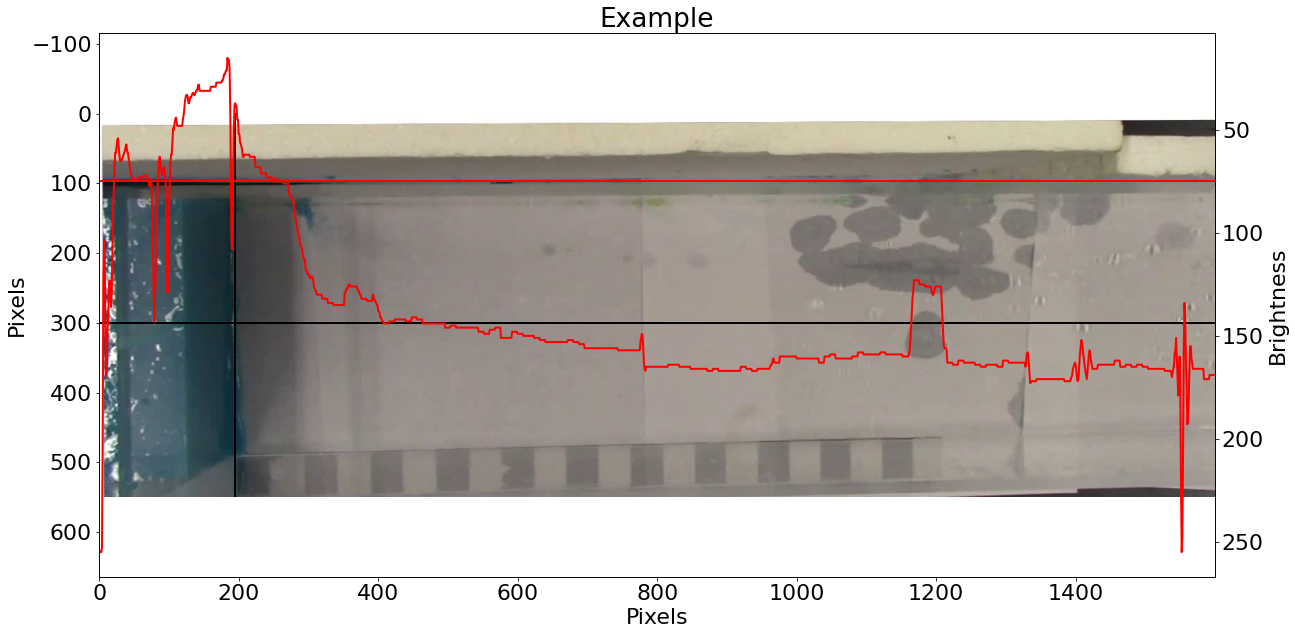

In [3]:
# plots initial frame for manually setting processing parameters

y2 = bottom - top - 1
x2 = right - left - 1

# read first frame from video
cap = cv2.VideoCapture(filename)
fps = cap.get(cv2.CAP_PROP_FPS)

ret, frame = cap.read()
if ret:
    pic = np.flip(frame,2)
    #pic = np.transpose(pic,axes=(1,0,2)) # uncomment for flow from top to bottom
cap.release()

# plot cropped image, profile for analysis
# x0 and yline in black
# threshold and profile along yline in red, choose such that threshold crosses 
# the profile along yline at the starting location x0
fig,ax = plt.subplots(figsize=(20,10))
ax.imshow(pic[top:bottom,left:right,:])
ax.plot([x0, x0], [0, y2], 'k')
ax.plot([1, x2], [yline-top, yline-top], 'k')
ax2 = ax.twinx() 
ax2.plot(pic[yline,left:right,channel], 'r')
ax2.plot([1, x2], [thresh, thresh], 'r')
ax2.invert_yaxis()
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax2.set_ylabel('Brightness')
ax.set_title(title_str);

### Extract flow front location over time from video

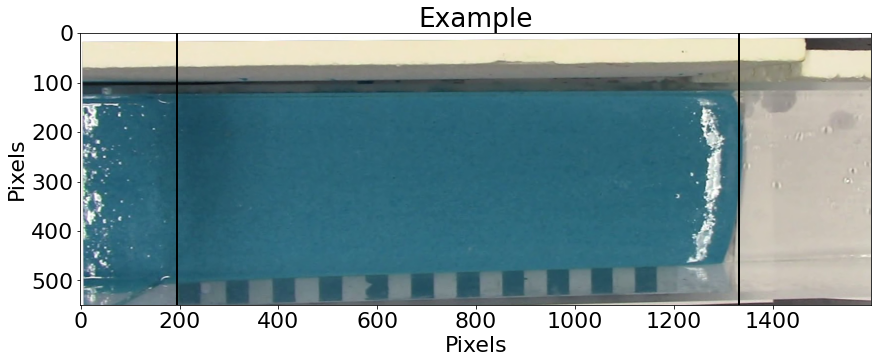

In [4]:
# Process video after setting parameters

currentFrame = 0

y2 = bottom - top - 1

# read video from start to end frame
cap = cv2.VideoCapture(filename)
fps = cap.get(cv2.CAP_PROP_FPS)
pos = np.zeros(endFrame-startFrame)

while(currentFrame<endFrame):
    ret, frame = cap.read()
    if currentFrame >= startFrame:
        if ret:
            pic = np.flip(frame,2)
            #pic = np.transpose(pic,axes=(1,0,2)) #turn on for flow from top to bottom
            if (pic[yline,left:right,channel]<thresh).any():
                pos[currentFrame - startFrame] = np.max(np.where(pic[yline,left:right,channel]<thresh))
            else:
                pos[currentFrame-startFrame] = 0
    
    currentFrame += 1
    
cap.release()

# plot final frame with starting and final locations in black
fig,ax = plt.subplots(figsize=(15,5))
ax.imshow(pic[top:bottom,left:right,:])
ax.plot([x0, x0], [0, y2], 'k')
ax.plot([pos[-1], pos[-1]], [0, y2], 'k')
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title(title_str);

### Set image scale

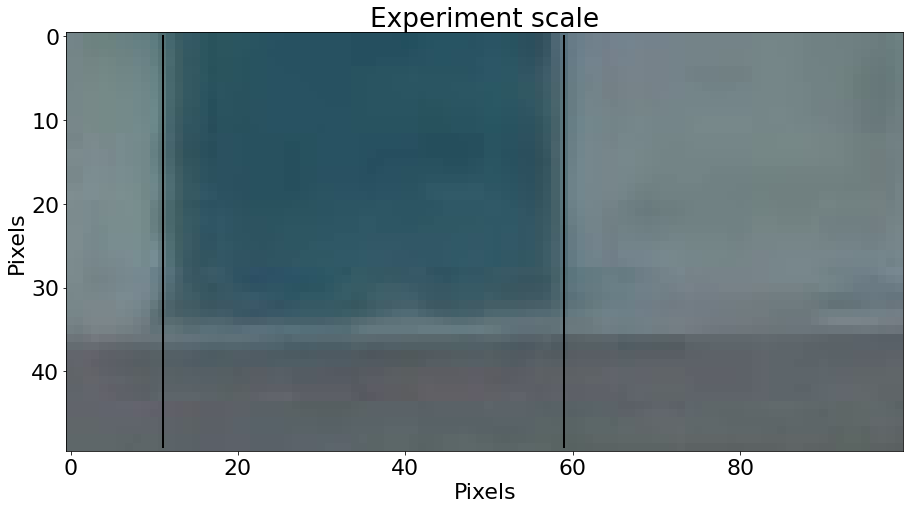

In [5]:
# Crop image
top2 = 500
bottom2 = 550
left2 = 750
right2 = 850

# Plot
fig,ax = plt.subplots(figsize=(15,20))
ax.imshow(pic[top2:bottom2,left2:right2,:])

# Set to distance W
lft = 11
rgt = 59

# Plot
ax.plot([lft, lft], [0, bottom2-top2-1], 'k')
ax.plot([rgt, rgt], [0, bottom2-top2-1], 'k')

# Determine scaling factors
W = 0.02 # m
k = W/(rgt-lft) # m/pixel
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title('Experiment scale');

### Scale distance and plot

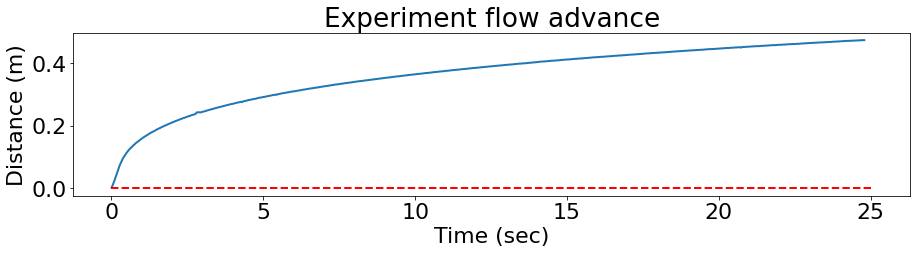

In [6]:
# scale time and front position
pos_scaled = (pos-x0)*k
pos_scaled[pos_scaled<0] = 0
t_scaled = np.arange((pos_scaled).size)/fps

t0 = 8.54 # Time of dam release [sec]
tf = 33.6 # End time [sec]

pos_scaled = pos_scaled[(t_scaled>t0) & (t_scaled<tf)]
t_scaled = t_scaled[(t_scaled>t0) & (t_scaled<tf)]-t0

# plot scaled front advance
fig,ax = plt.subplots(figsize=(15,3))
ax.plot(t_scaled, pos_scaled)
ax.plot([0, tf - t0], [0, 0], 'r--')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Distance (m)')
ax.set_title('Experiment flow advance');

### Write time-distance data for the flow front to a file

In [7]:
# Save data to file

df = pd.DataFrame({'X_pos':pos_scaled, 'Time':t_scaled})
meta = pd.DataFrame({'H':H, 'L':L, 'K_fluid':K_fluid, 'Rho':rho, 'Slope':theta, 'Title':title_str, 'Temp':T,
                    'Phi_solid':phi_solid, 'Phi_gas':phi_gas, 'Particle':particle}, index=[0])

df.to_hdf(title_str + '.h5', key='df', mode='w')
meta.to_hdf(title_str + '.h5', key='meta', mode='a')

### Set starting point for EnKF inversion
Fitting for a Herschel-Bulkley fluid on an inclined plane following derivation from Liu & Mei (1989), Balmforth et al. (2007):

$ \frac{\partial h}{\partial t} = -\left( \frac{\rho g}{K} \right)^{1/n} \frac{\partial}{\partial x} \left[ \frac{n \left| \sin{\theta} - \cos{\theta} \frac{\partial h}{\partial x} \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \sin{\theta} -  \cos{\theta} \frac{\partial h}{\partial x} \right) \right] $

$ Y = h - \frac{\tau_y}{\rho g |\sin{\theta} -\cos{\theta} \frac{\partial h}{\partial x}|} $

In [8]:
# Setup model for MCMC

def lnlike(mu, x, y, yerr):
    K, tauy, n = mu
    
    X = np.zeros_like(t_scaled)

    threshold = 0.0001
    for j in np.arange(t_scaled.shape[0]):
        X[j] = x_grid[np.max(np.nonzero(h[j*25,:]>threshold)) + 1] # find node with h>threshold
    ind = np.nonzero(X[1:] - X[:-1])[0]
    model = np.interp(t_match,t_match[ind],X[ind])

    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*yerr**2)))

In [9]:
# Initial guesses for EnKF
K_guess = 18
tauy_guess = 0.01
n_guess = 1.0

# Define model resolution for EnKF
x_grid = np.linspace(0,0.75,52) # can change maximum length and discretization
t_res = 50 # integer factor to decrease time step dt = 1/(t_res * frame rate), increase to improve stability

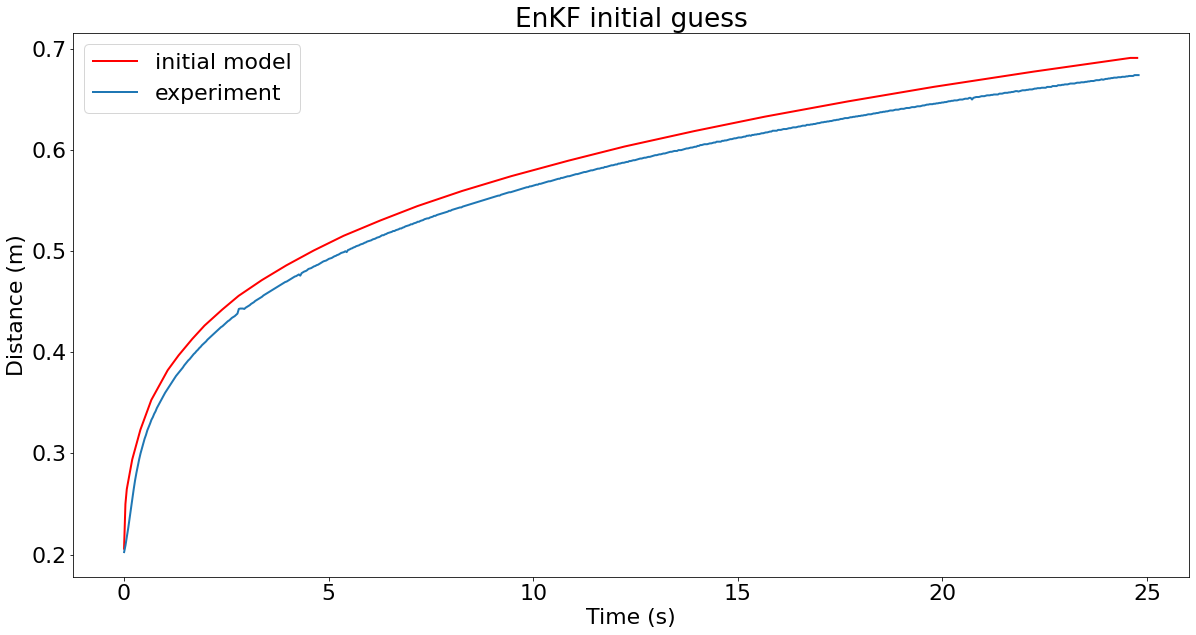

In [13]:
dx = x_grid[1] - x_grid[0]
yerr = 2*dx
h0 = np.zeros_like(x_grid)
h0[x_grid<L] = H

h, t = dambreak(x_grid, h0, 0, rho, K_guess, tauy_guess, n_guess, 9.81, t_scaled[-1], t_res*t_scaled.shape[0])
X = np.zeros_like(t_scaled)
t_match = np.zeros_like(t_scaled)

threshold = 0.0001
for j in np.arange(t_scaled.shape[0]):
    X[j] = x_grid[np.max(np.nonzero(h[j*t_res,:]>threshold)) + 1] # find node with h>threshold
    t_match[j] = t[j*t_res]
    ind = np.nonzero(X[1:] - X[:-1])[0]
    model = np.interp(t_match,t_match[ind],X[ind]) # smooth over grid size

# Plot front advance
fig,ax = plt.subplots(figsize=(20,10))

ax.plot(t_match,model,'r-',label='initial model');
ax.plot(t_scaled,pos_scaled+L,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('EnKF initial guess')
ax.legend();

In [11]:
# Save guesses to file

meta['K_guess'] = K_guess
meta['tauy_guess'] = tauy_guess
meta['n_guess'] = n_guess

meta.to_hdf(title_str + '.h5', key='meta', mode='a')